In [82]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# import chart_studio.tools as tls

In [83]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



07-18-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-07-18,199.590516,7.693353e+08,199.590516,NaN,NaN,NaN,NaN,NaN
2017-07-19,223.461348,7.317111e+08,218.156719,23.870833,NaN,NaN,NaN,NaN
2017-07-20,217.086474,3.903940e+08,217.374002,-6.374874,NaN,NaN,NaN,NaN
2017-07-21,231.143529,2.299701e+08,227.275360,14.057055,NaN,NaN,NaN,NaN
2017-07-22,226.718599,2.044678e+08,226.876915,-4.424930,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-13,1112.920783,1.793689e+10,1098.951561,72.123637,41.988562,-67.788266,17.479501,-85.267768
2022-07-14,1191.130837,1.647422e+10,1164.793901,78.210054,48.359970,-58.631347,21.309137,-79.940484
2022-07-15,1234.099139,1.681719e+10,1214.297642,42.968302,51.511001,-47.361288,26.063357,-73.424645


In [84]:
mydf.dropna(inplace=True)
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [85]:
my_data = mydf[myCols]
display(my_data)
my_data.corr()

,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,macd_h,macd_s,ethereum_diff
date,,,,,,,,
2017-08-20,322.201220,1.743910e+09,314.608812,72.710533,21.695937,-1.282863,22.978801,27.029643
2017-08-21,312.174471,8.983443e+08,312.869997,66.833657,21.461654,-1.213717,22.675371,-10.026750
2017-08-22,316.788920,4.664746e+08,315.669228,68.109494,21.401625,-1.018997,22.420622,4.614450
2017-08-23,321.785298,3.977527e+08,320.037850,69.480771,21.509273,-0.729079,22.238352,4.996378
2017-08-24,329.025281,4.519507e+08,326.457443,71.398576,21.926041,-0.249849,22.175890,7.239983
...,...,...,...,...,...,...,...,...
2022-07-13,1112.920783,1.793689e+10,1098.951561,41.988562,-67.788266,17.479501,-85.267768,72.123637
2022-07-14,1191.130837,1.647422e+10,1164.793901,48.359970,-58.631347,21.309137,-79.940484,78.210054
2022-07-15,1234.099139,1.681719e+10,1214.297642,51.511001,-47.361288,26.063357,-73.424645,42.968302


,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,macd_h,macd_s,ethereum_diff
ethereum,1.000000,0.532750,0.999824,0.089335,0.184627,-0.002583,0.196347,0.030473
ethereum_volume,0.532750,1.000000,0.533796,0.231137,0.277839,-0.114700,0.329923,-0.041429
ethereum_ewm,0.999824,0.533796,1.000000,0.083592,0.182400,-0.008287,0.195761,0.012485
ethereum_rsi,0.089335,0.231137,0.083592,1.000000,0.603436,0.393597,0.516769,0.233500
macd,0.184627,0.277839,0.182400,0.603436,1.000000,0.331665,0.956034,0.073110
macd_h,-0.002583,-0.114700,-0.008287,0.393597,0.331665,1.000000,0.040426,0.191380
macd_s,0.196347,0.329923,0.195761,0.516769,0.956034,0.040426,1.000000,0.017942
ethereum_diff,0.030473,-0.041429,0.012485,0.233500,0.073110,0.191380,0.017942,1.000000


## Linear Regression, no scale, shift data to predict off of yesterdays info

X_train: 
(1772, 7)
X_test: 
(20, 7)
y_train: 
(1772,)
y_test: 
(20,)
linear regression with no scaling
Root Mean squared error: 56.54
               ethereum   pred_shift
date                                
2022-06-28  1143.533536  1201.832275
2022-06-29  1098.905518  1153.129352
2022-06-30  1057.630999  1110.341402
2022-07-01  1068.819440  1068.134350
2022-07-02  1068.541503  1074.815530
2022-07-03  1074.607318  1069.173921
2022-07-04  1153.348315  1074.035749
2022-07-05  1134.017070  1149.904465
2022-07-06  1188.725643  1133.429188
2022-07-07  1240.378406  1189.298671
2022-07-08  1233.514679  1238.439309
2022-07-09  1216.849707  1236.197303
2022-07-10  1169.012708  1222.293988
2022-07-11  1097.449438  1177.942752
2022-07-12  1040.797146  1109.251572
2022-07-13  1112.920783  1051.782700
2022-07-14  1191.130837  1115.386400
2022-07-15  1234.099139  1184.592342
2022-07-16  1355.045640  1228.737592
2022-07-17  1332.313174  1348.262517


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


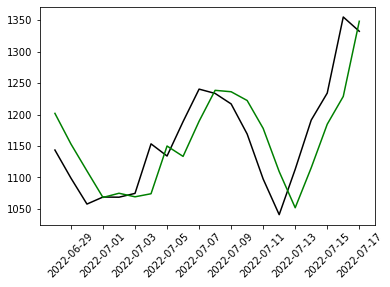

In [86]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X.drop(index=X.index[-1], 
        axis=0, 
        inplace=True)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-20]
X_test = X[-20:]
y_train = y[:-20]
y_test = y[-20:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The mean squared error
print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

y_check1 = pd.DataFrame(y_test)
# print(y_check1)
y_check1['pred_shift']= y_pred
print(y_check1)
plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
plt.plot(y_check1.index,y_check1['pred_shift'], color = 'green')
plt.xticks(rotation=45)
plt.show()

## Linear Regression, scaled, shift data to predict off of yesterdays info

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.80524527, -0.61345441,  1.51338038, ..., -0.04183803,
         0.2262761 ,  0.33744504],
       [-0.86646453, -0.61487521,  1.09763962, ..., -0.03917685,
         0.22264788, -0.13552582],
       [-0.89773206, -0.61258794,  1.18789464, ..., -0.03168275,
         0.21960174,  0.05134776],
       ...,
       [ 0.26123506,  0.08123622, -0.20922199, ...,  0.82764619,
        -1.00436896,  0.99068843],
       [ 0.2860663 ,  0.12168599,  0.01368761, ...,  1.01061889,
        -0.92645659,  0.5408788 ],
       [ 0.44597243,  0.20383307,  0.54912032, ...,  1.39554001,
        -0.81864631,  1.53615691]])

X_train: 
(1772, 7)
X_test: 
(20, 7)
y_train: 
(1772,)
y_test: 
(20,)
linear regression with no scaling
Root Mean squared error: 56.54
               ethereum  pred_linear_reg
date                                    
2022-06-28  1143.533536      1201.832275
2022-06-29  1098.905518      1153.129352
2022-06-30  1057.630999      1110.341402
2022-07-01  1068.819440      1068.134350
2022-07-02  1068.541503      1074.815530
2022-07-03  1074.607318      1069.173921
2022-07-04  1153.348315      1074.035749
2022-07-05  1134.017070      1149.904465
2022-07-06  1188.725643      1133.429188
2022-07-07  1240.378406      1189.298671
2022-07-08  1233.514679      1238.439309
2022-07-09  1216.849707      1236.197303
2022-07-10  1169.012708      1222.293988
2022-07-11  1097.449438      1177.942752
2022-07-12  1040.797146      1109.251572
2022-07-13  1112.920783      1051.782700
2022-07-14  1191.130837      1115.386400
2022-07-15  1234.099139      1184.592342
2022-07-16  1355.045640      1228.737592
2022

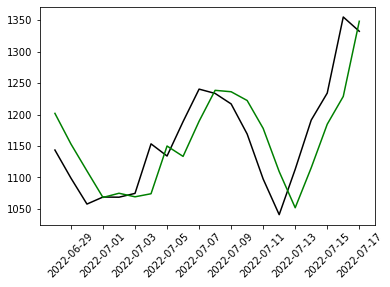

In [87]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-20]
X_test = X[-20:]
y_train = y[:-20]
y_test = y[-20:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
# The mean squared error
print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

y_check1 = pd.DataFrame(y_test)
# print(y_check1)
y_check1['pred_linear_reg']= y_pred
print(y_check1)
plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
plt.plot(y_check1.index,y_check1['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.show()

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)
C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([[-0.80524527, -0.61345441,  1.51338038, ..., -0.04183803,
         0.2262761 ,  0.33744504],
       [-0.86646453, -0.61487521,  1.09763962, ..., -0.03917685,
         0.22264788, -0.13552582],
       [-0.89773206, -0.61258794,  1.18789464, ..., -0.03168275,
         0.21960174,  0.05134776],
       ...,
       [ 0.26123506,  0.08123622, -0.20922199, ...,  0.82764619,
        -1.00436896,  0.99068843],
       [ 0.2860663 ,  0.12168599,  0.01368761, ...,  1.01061889,
        -0.92645659,  0.5408788 ],
       [ 0.44597243,  0.20383307,  0.54912032, ...,  1.39554001,
        -0.81864631,  1.53615691]])

X_train: 
(1772, 7)
X_test: 
(20, 7)
y_train: 
(1772,)
y_test: 
(20,)


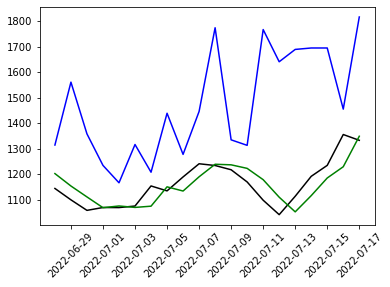

In [88]:
# X = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'ethereum_diff']]
X_raw = my_data[['ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']]
y = my_data['ethereum']
scaler=StandardScaler()
# Drop first row of prices
y.drop(index=y.index[0], 
        axis=0, 
        inplace=True)
#dropping last row of features
X_raw.drop(index=X_raw.index[-1], 
        axis=0, 
        inplace=True)
X=scaler.fit_transform(X_raw)
display(X)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_train = X[:-20]
X_test = X[-20:]
y_train = y[:-20]
y_test = y[-20:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
preds=xg_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)

y_check1['pred_xgb']= preds
plt.plot(y_check1.index,y_check1['ethereum'], color = 'black')
plt.plot(y_check1.index,y_check1['pred_linear_reg'], color = 'green')
plt.plot(y_check1.index,y_check1['pred_xgb'], color = 'blue')
plt.xticks(rotation=45)
plt.show()

In [89]:
print(type(mydf))
mydf.reset_index(inplace=True)
display(mydf)
# print(df.rolling(window = 4))
# mydf[["ethereum_volume"]] = mydf.rolling(3).mean()
# mydf.rolling(window=4)

<class 'pandas.core.frame.DataFrame'>


,date,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
0,2017-08-20,322.201220,1.743910e+09,314.608812,27.029643,72.710533,21.695937,-1.282863,22.978801
1,2017-08-21,312.174471,8.983443e+08,312.869997,-10.026750,66.833657,21.461654,-1.213717,22.675371
2,2017-08-22,316.788920,4.664746e+08,315.669228,4.614450,68.109494,21.401625,-1.018997,22.420622
3,2017-08-23,321.785298,3.977527e+08,320.037850,4.996378,69.480771,21.509273,-0.729079,22.238352
4,2017-08-24,329.025281,4.519507e+08,326.457443,7.239983,71.398576,21.926041,-0.249849,22.175890
...,...,...,...,...,...,...,...,...,...
1788,2022-07-13,1112.920783,1.793689e+10,1098.951561,72.123637,41.988562,-67.788266,17.479501,-85.267768
1789,2022-07-14,1191.130837,1.647422e+10,1164.793901,78.210054,48.359970,-58.631347,21.309137,-79.940484
1790,2022-07-15,1234.099139,1.681719e+10,1214.297642,42.968302,51.511001,-47.361288,26.063357,-73.424645
1791,2022-07-16,1355.045640,1.902583e+10,1314.831927,120.946501,59.079833,-28.343586,36.064847,-64.408433


In [90]:


an_array = np.empty((len(mydf.columns)))

an_array[:] = np.NaN
an_array= an_array.tolist()
print(type(an_array))
print(an_array)
mydf.loc[len(mydf.index)] = an_array
display(mydf.tail(5))

<class 'list'>
[nan, nan, nan, nan, nan, nan, nan, nan, nan]


,date,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
1789,2022-07-14,1191.130837,1.647422e+10,1164.793901,78.210054,48.359970,-58.631347,21.309137,-79.940484
1790,2022-07-15,1234.099139,1.681719e+10,1214.297642,42.968302,51.511001,-47.361288,26.063357,-73.424645
1791,2022-07-16,1355.045640,1.902583e+10,1314.831927,120.946501,59.079833,-28.343586,36.064847,-64.408433
1792,2022-07-17,1332.313174,1.665640e+10,1327.318532,-22.732466,57.270596,-14.934089,39.579475,-54.513564
1793,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# appending a row of fake data
rollingLength = 5
qFakeData = 5
testx = mydf.drop(['date', 'ethereum'], axis=1)
rollingRow = []
for x in range(qFakeData):
#     print(x)
    for i in testx.columns:
        rollingRow.append(testx[i].tail(5).mean())
    print(rollingRow)
    testx.loc[len(testx)] = rollingRow
    rollingRow=[]
display(testx)



print(mydf['ethereum_volume'].tail(3).mean())
# display(mydf.tail(4))

[17243413616.931522, 1255.3105004112576, 54.84809776374607, 54.05535014921914, -37.31757754612511, 30.75420372117628, -68.07178126730139]
[17435711055.999718, 1277.9396502689153, 49.0076086024188, 55.47919523468151, -31.98913520454161, 33.115470468108384, -65.10460567265]
[17590340093.937172, 1293.8501522346132, 50.517435286520815, 56.47124368672068, -28.146097013735464, 34.87849894950733, -63.024595963242795]
[17231467228.69329, 1288.6047086536344, 32.91016879735911, 55.81909623957101, -28.09672477128924, 34.58191198153247, -62.67863675282171]
[17375232998.890427, 1278.9262528921051, 46.8208276125112, 55.45622132754809, -31.38738363392286, 33.33252128008112, -64.71990491400398]


,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
0,1.743910e+09,314.608812,27.029643,72.710533,21.695937,-1.282863,22.978801
1,8.983443e+08,312.869997,-10.026750,66.833657,21.461654,-1.213717,22.675371
2,4.664746e+08,315.669228,4.614450,68.109494,21.401625,-1.018997,22.420622
3,3.977527e+08,320.037850,4.996378,69.480771,21.509273,-0.729079,22.238352
4,4.519507e+08,326.457443,7.239983,71.398576,21.926041,-0.249849,22.175890
...,...,...,...,...,...,...,...
1794,1.724341e+10,1255.310500,54.848098,54.055350,-37.317578,30.754204,-68.071781
1795,1.743571e+10,1277.939650,49.007609,55.479195,-31.989135,33.115470,-65.104606
1796,1.759034e+10,1293.850152,50.517435,56.471244,-28.146097,34.878499,-63.024596
1797,1.723147e+10,1288.604709,32.910169,55.819096,-28.096725,34.581912,-62.678637


17841117851.408722
